# Preprocessing of Antibody capture single cell data
Additionally to capturing only transcriptomic data with single cell analyses, we are now able to also capture the abundance of surface protein expression additionally \cite{https://www.nature.com/articles/nmeth.4380}.
This additional modality requires different preprocessing compared to what we described in section \link{preprocessing} as data distributions are different. In the following, we will guide you through preprocessing ADT data.
## Introduction
By using barcode tagged antibodies, it is possible to first bind the antibodies to the cells and later sequence the barcodes together with the RNA

![CITE-Seq not sure if we can use this?](https://citeseq.files.wordpress.com/2017/10/antibody_transparent.png)

This allows us to identify cell types based on conventional markers from flow cytometry experiments which is especially useful for specific immune cell populations.
Contrary to the negative binomial distribution of UMI counts, ADT data follows a different distribution. The data is noisier, as unbound antibodies lead to counts in cells or empty droplets where the protein is not present.

Due to this different approaches for quality control and normalisation are needed. Furthermore, the data contains fewer features as antibody panels are limited to up to 100 features, contrary to around 20.000 features in the gene expression space.

## Importing the data
In this tutorial, we will use scanpy and muon to analyse the data.

In [3]:
import scanpy as sc
import muon as mu
import pandas as pd
import numpy as np
import glob

## Reading the data
We're reading in the data with muon, this way we already have two subobjects, one for RNA and ADT counts each

In [5]:
filtered_files = glob.glob('/Users/daniel.strobl/extended-single-cell-best-practices/neurips/s*d*/filtered_*/')

In [6]:
raw_files = glob.glob('/Users/daniel.strobl/extended-single-cell-best-practices/neurips/s*d*/raw_*/')

In [70]:
filtered_mu = {}
for i in filtered_files:
    name = i.split('/')[5]
    filtered_mu[name]=mu.read_10x_mtx(i)
    filtered_mu[name]['prot'].obs['donor']=name
    filtered_mu[name]['rna'].obs['donor']=name
    
filtered = filtered_mu.pop('s1d1')
filtered_rna = filtered['rna']
filtered_prot = filtered['prot']
for i in filtered_mu.keys():
    filtered_rna = filtered_rna.concatenate(filtered_mu[i]['rna'])
    filtered_prot = filtered_prot.concatenate(filtered_mu[i]['prot'])
filtered = mu.MuData({'rna':filtered_rna, 'prot': filtered_prot})
del filtered_mu

In [71]:
raw_mu = {}
for i in raw_files:
    name = i.split('/')[5]
    raw_mu[name]=mu.read_10x_mtx(i)
    raw_mu[name]['prot'].obs['donor']=name
    raw_mu[name]['rna'].obs['donor']=name
    
raw = raw_mu.pop('s1d1')
raw_rna = raw['rna']
raw_prot = raw['prot']
for i in raw_mu.keys():
    raw_rna = raw_rna.concatenate(raw_mu[i]['rna'])
    raw_prot = raw_prot.concatenate(raw_mu[i]['prot'])
raw = mu.MuData({'rna':raw_rna, 'prot': raw_prot})
del raw_mu

In [72]:
filtered

MuData object with n_obs × n_vars = 93130 × 36741
  var:	'feature_types', 'gene_ids'
  2 modalities
    rna:	93130 x 36601
      obs:	'donor', 'batch'
      var:	'gene_ids', 'feature_types'
    prot:	93130 x 140
      obs:	'donor', 'batch'
      var:	'gene_ids', 'feature_types'

In [73]:
raw

MuData object with n_obs × n_vars = 19958064 × 36741
  var:	'feature_types', 'gene_ids'
  2 modalities
    rna:	19958064 x 36601
      obs:	'donor', 'batch'
      var:	'gene_ids', 'feature_types'
    prot:	19958064 x 140
      obs:	'donor', 'batch'
      var:	'gene_ids', 'feature_types'

## QC of the data
Similar to the qc and filtering of RNA data, we also need to preprocess ADT data. Empty droplets still contain reads for ADT counts, as unbound antibodies are sequenced. We can, however make use of these empty droplets to normalise our count data as we can consider this as the ambient background level for each antibody.

In [12]:
data['prot'].X

<1752478x140 sparse matrix of type '<class 'numpy.float32'>'
	with 6028188 stored elements in Compressed Sparse Row format>

In [74]:
sc.pp.calculate_qc_metrics(filtered['prot'], inplace=True, percent_top=None)

In [75]:
sc.pp.calculate_qc_metrics(raw['prot'], inplace=True, percent_top=None)

In [76]:
import seaborn as sns

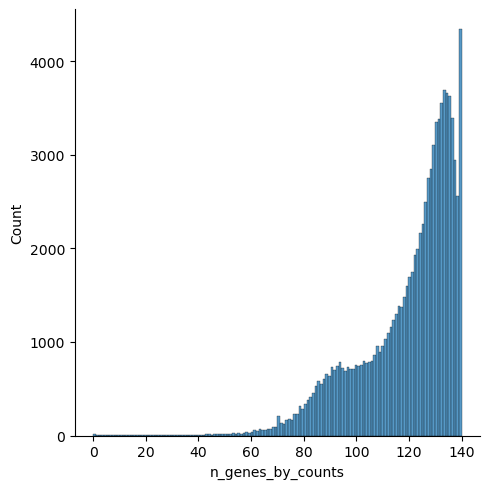

In [77]:
sns.displot(filtered['prot'].obs.n_genes_by_counts)

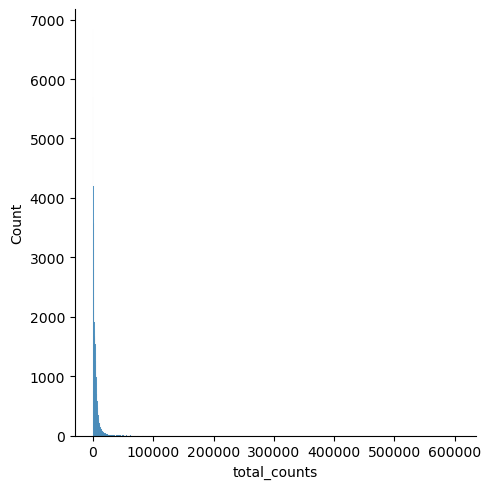

In [78]:
sns.displot(filtered['prot'].obs.total_counts)

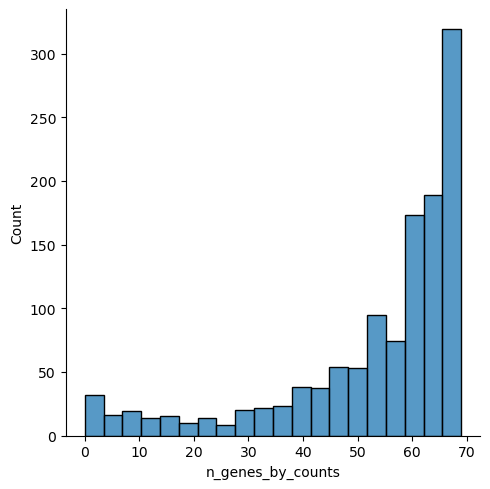

In [79]:
sns.displot(filtered['prot'][filtered['prot'].obs.n_genes_by_counts<70].obs.n_genes_by_counts)

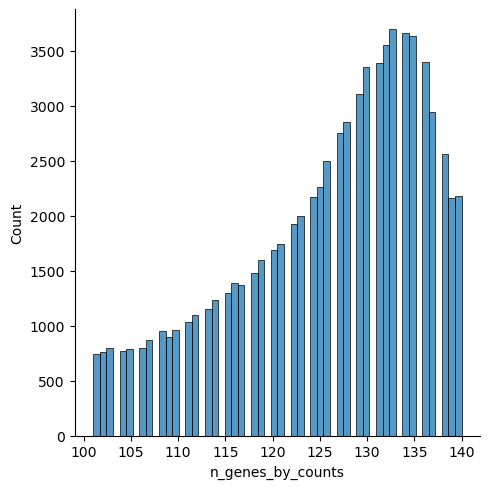

In [80]:
sns.displot(filtered['prot'][filtered['prot'].obs.n_genes_by_counts>100].obs.n_genes_by_counts)

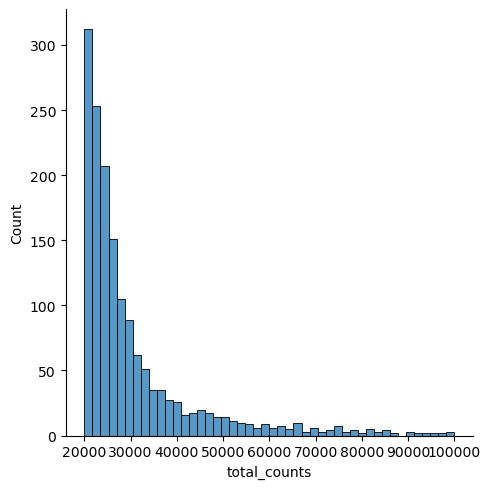

In [81]:
sns.displot(filtered['prot'].obs.query('total_counts>20000 and total_counts<100000').total_counts)

/Users/daniel.strobl/mambaforge/envs/cite/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='n_genes_by_counts', ylabel='total_counts'>

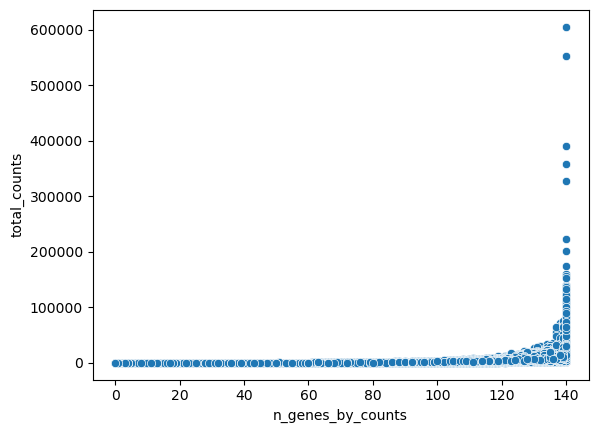

In [82]:
sns.scatterplot(filtered['prot'].obs.n_genes_by_counts, filtered['prot'].obs.total_counts)

In [83]:
sc.pp.filter_cells(filtered['prot'], min_genes=55)

In [84]:
sc.pp.filter_cells(filtered['prot'], max_counts=60000)

/Users/daniel.strobl/mambaforge/envs/cite/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='n_genes_by_counts', ylabel='total_counts'>

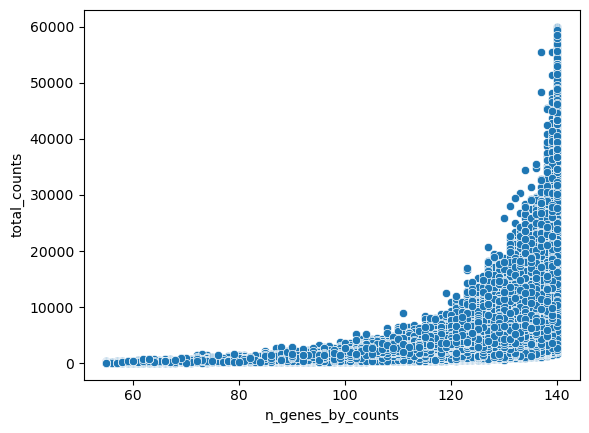

In [85]:
sns.scatterplot(filtered['prot'].obs.n_genes_by_counts, filtered['prot'].obs.total_counts)

In [86]:
filtered

MuData object with n_obs × n_vars = 93130 × 36741
  var:	'feature_types', 'gene_ids'
  2 modalities
    rna:	93130 x 36601
      obs:	'donor', 'batch'
      var:	'gene_ids', 'feature_types'
    prot:	92569 x 140
      obs:	'donor', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts'
      var:	'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [87]:
raw['rna'].obs["log10umi"] = np.array(np.log10(raw['rna'].X.sum(axis=1) + 1)).reshape(-1)

In [88]:
raw['prot'].obs["log10umi"] = np.array(np.log10(raw['prot'].X.sum(axis=1) + 1)).reshape(-1)

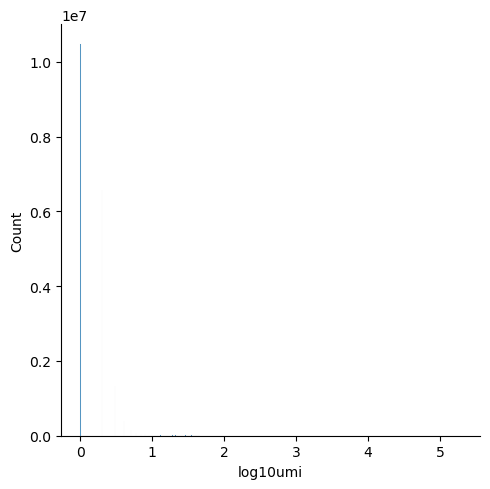

In [57]:
sns.displot(raw['rna'].obs.log10umi)

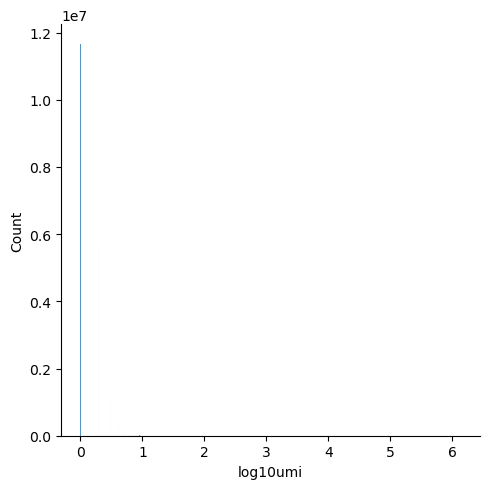

In [61]:
sns.displot(raw['prot'].obs.log10umi)

## Normalisation
Next, we're normalising the data. As we have the raw data available, we can use the background distribution to normalise against.
Here, we also have isotype controls available, meaning antibodies that bind nonspecifically to the cells, thus giving us a background to compare against.
We're calling the normalisation function `mu.prot.pp.dsb` with the filtered and raw mudata object as well as the names of the isotype controls.

In [89]:
isotype_controls = ['Mouse-IgG1', 'Mouse-IgG2a', 'Mouse-IgG2b', 'Rat-IgG2b']

In [90]:
filtered['prot'].layers['counts'] = filtered['prot'].X

In [91]:
mu.prot.pp.dsb(filtered, raw, isotype_controls=isotype_controls)

/Users/daniel.strobl/mambaforge/envs/cite/lib/python3.10/site-packages/muon/_prot/preproc.py:109: UserWarning: empty_counts_range values are not provided, treating all the non-cells as empty droplets
  warn(


In [92]:
sc.pp.pca(filtered['prot'], svd_solver='arpack')

In [93]:
sc.pp.neighbors(filtered['prot'])

In [94]:
sc.tl.umap(filtered['prot'])

In [95]:
filtered['prot'].var.index[:50]

Index(['CD86-1', 'CD274-1', 'CD270', 'CD155', 'CD112', 'CD47-1', 'CD48-1',
       'CD40-1', 'CD154', 'CD52-1', 'CD3', 'CD8', 'CD56', 'CD19-1', 'CD33-1',
       'CD11c', 'HLA-A-B-C', 'CD45RA', 'CD123', 'CD7-1', 'CD105', 'CD49f',
       'CD194', 'CD4-1', 'CD44-1', 'CD14-1', 'CD16', 'CD25', 'CD45RO', 'CD279',
       'TIGIT-1', 'Mouse-IgG1', 'Mouse-IgG2a', 'Mouse-IgG2b', 'Rat-IgG2b',
       'CD20', 'CD335', 'CD31', 'Podoplanin', 'CD146', 'IgM', 'CD5-1', 'CD195',
       'CD32', 'CD196', 'CD185', 'CD103', 'CD69-1', 'CD62L', 'CD161'],
      dtype='object')

/Users/daniel.strobl/mambaforge/envs/cite/lib/python3.10/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'donor' as categorical
/Users/daniel.strobl/mambaforge/envs/cite/lib/python3.10/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical


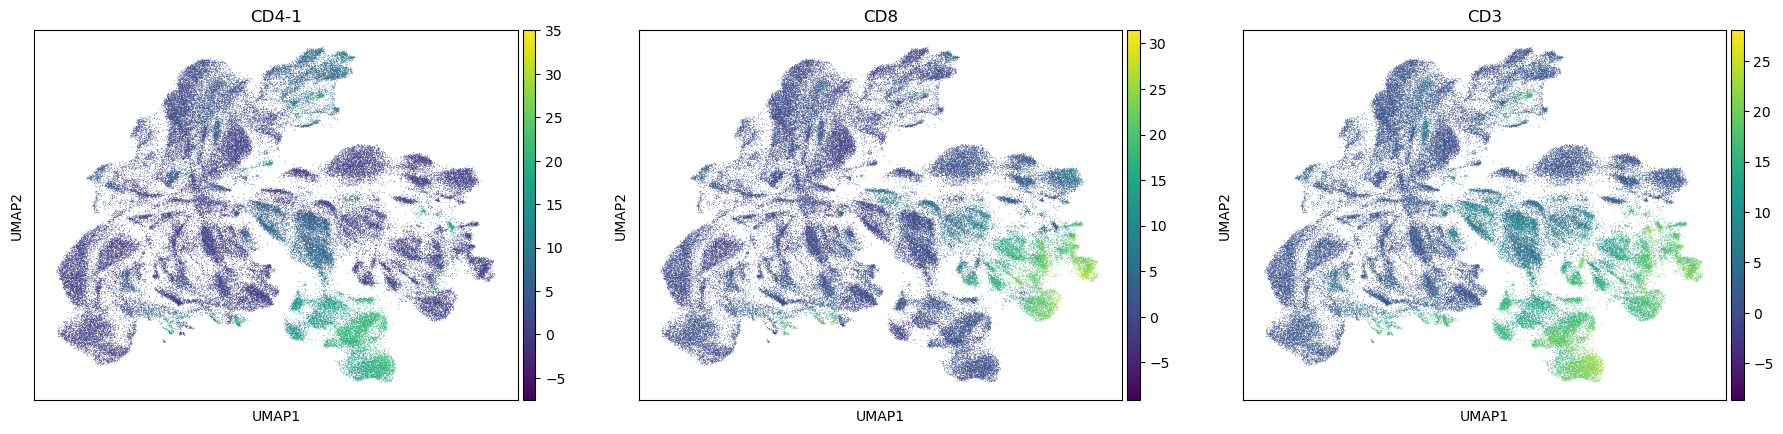

In [96]:
sc.pl.umap(filtered['prot'], color=['CD4-1', 'CD8', 'CD3'])

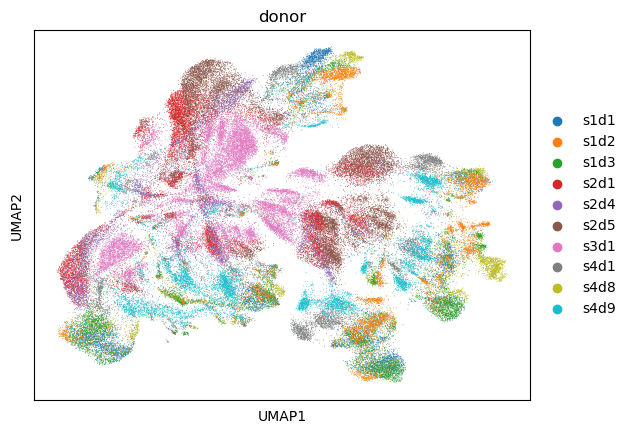

In [97]:
sc.pl.umap(filtered['prot'], color='donor')

In [107]:
sc.tl.leiden(filtered['prot'], resolution=0.2)

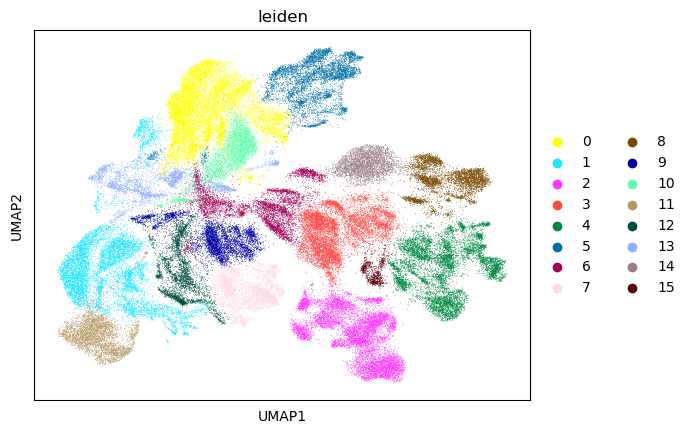

In [108]:
sc.pl.umap(filtered['prot'], color='leiden')

In [109]:
sc.tl.rank_genes_groups(filtered['prot'], groupby='leiden')

/Users/daniel.strobl/mambaforge/envs/cite/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/daniel.strobl/mambaforge/envs/cite/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/daniel.strobl/mambaforge/envs/cite/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/daniel.strobl/mambaforge/envs/cite/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/daniel.strobl/mambaforge/envs/cite/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value

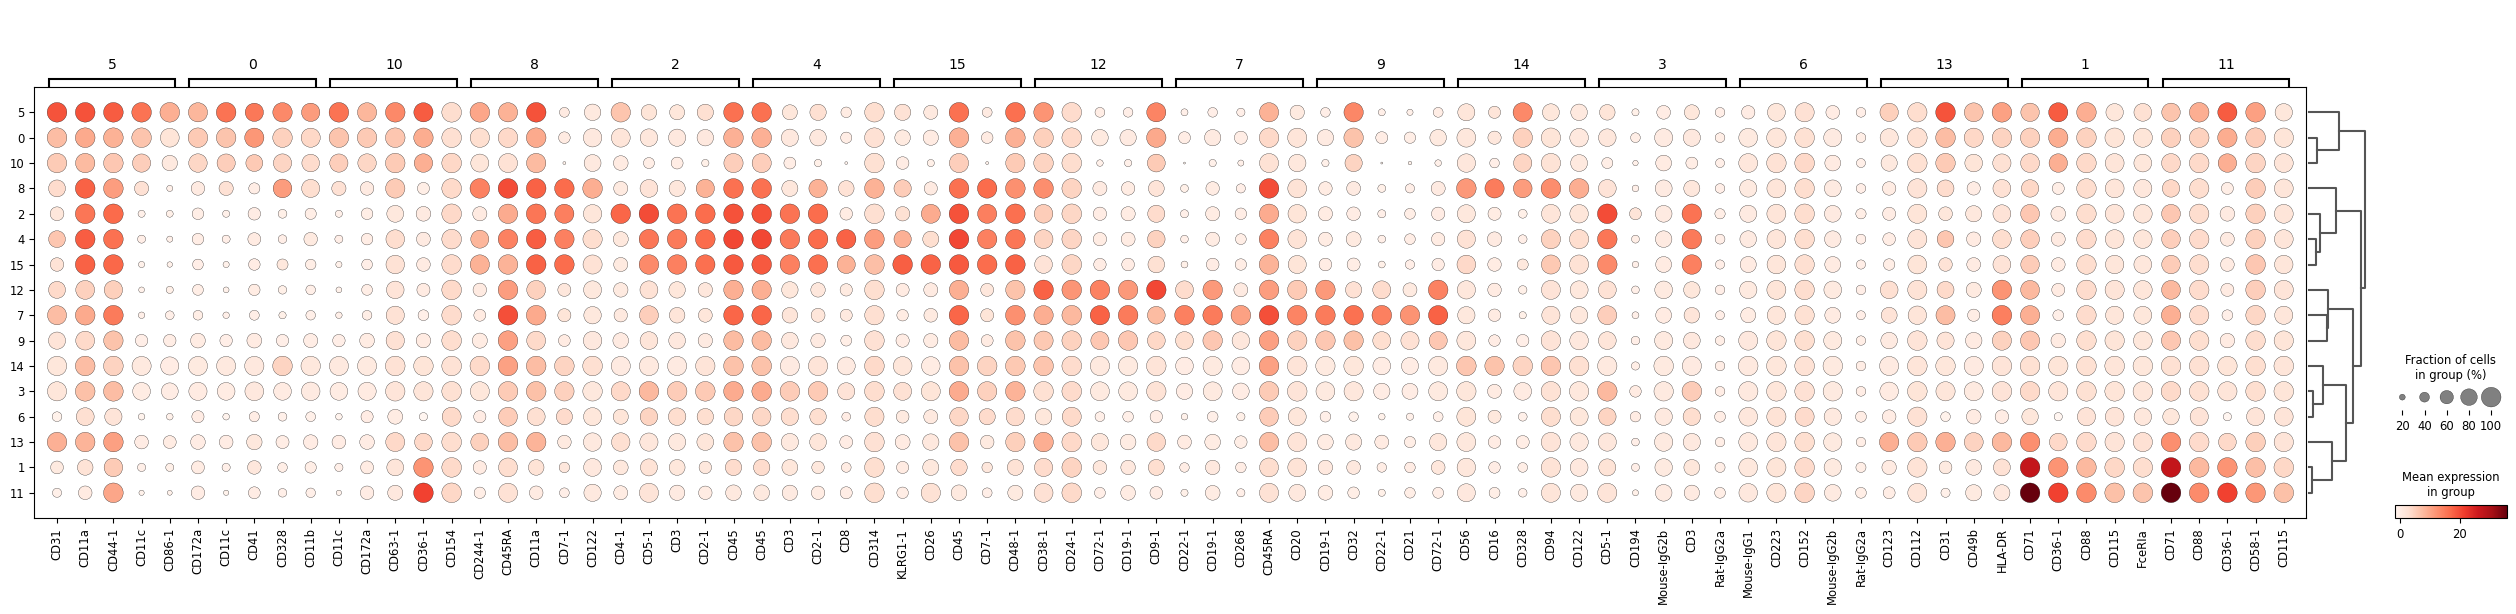

In [113]:
sc.pl.rank_genes_groups_dotplot(filtered['prot'], n_genes=5)